# 1 Load Neccessary Libraries 

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
from datetime import datetime
from scipy.stats import ttest_ind

# 2 Load Data

In [4]:
transactions = pd.read_excel(r"C:\Users\Nonopha\Downloads\QVI_transaction_data.xlsx")
customers = pd.read_csv(r"C:\Users\Nonopha\Downloads\QVI_purchase_behaviour.csv")

# 3 Initial Data Exploration (quick preview) 

In [6]:
print(transactions.head())
print(transactions.info())
print(customers.head())

    DATE  STORE_NBR  LYLTY_CARD_NBR  TXN_ID  PROD_NBR  \
0  43390          1            1000       1         5   
1  43599          1            1307     348        66   
2  43605          1            1343     383        61   
3  43329          2            2373     974        69   
4  43330          2            2426    1038       108   

                                  PROD_NAME  PROD_QTY  TOT_SALES  
0    Natural Chip        Compny SeaSalt175g         2        6.0  
1                  CCs Nacho Cheese    175g         3        6.3  
2    Smiths Crinkle Cut  Chips Chicken 170g         2        2.9  
3    Smiths Chip Thinly  S/Cream&Onion 175g         5       15.0  
4  Kettle Tortilla ChpsHny&Jlpno Chili 150g         3       13.8  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 264836 entries, 0 to 264835
Data columns (total 8 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   DATE            264836 non-null  int64  
 1   ST

# 4 Clean Transaction date column

In [8]:
transactions['DATE'] = pd.to_datetime('1899-12-30') + pd.to_timedelta(transactions['DATE'], unit='D')


# 5 Remove Non-Chip Products (e.g., Salsa)

In [10]:
# Identify product names that contain 'salsa'
transactions = transactions[~transactions['PROD_NAME'].str.lower().str.contains('salsa')]


# 6  Check dataset for Outliers

In [12]:
# Look at unusually high product quantities
print(transactions[transactions['PROD_QTY'] >= 200])

# Filter out that customer
outlier_customer = transactions.loc[transactions['PROD_QTY'] >= 200, 'LYLTY_CARD_NBR'].values[0]
transactions = transactions[transactions['LYLTY_CARD_NBR'] != outlier_customer]


            DATE  STORE_NBR  LYLTY_CARD_NBR  TXN_ID  PROD_NBR  \
69762 2018-08-19        226          226000  226201         4   
69763 2019-05-20        226          226000  226210         4   

                              PROD_NAME  PROD_QTY  TOT_SALES  
69762  Dorito Corn Chp     Supreme 380g       200      650.0  
69763  Dorito Corn Chp     Supreme 380g       200      650.0  


# 7 Check for Missing Dates

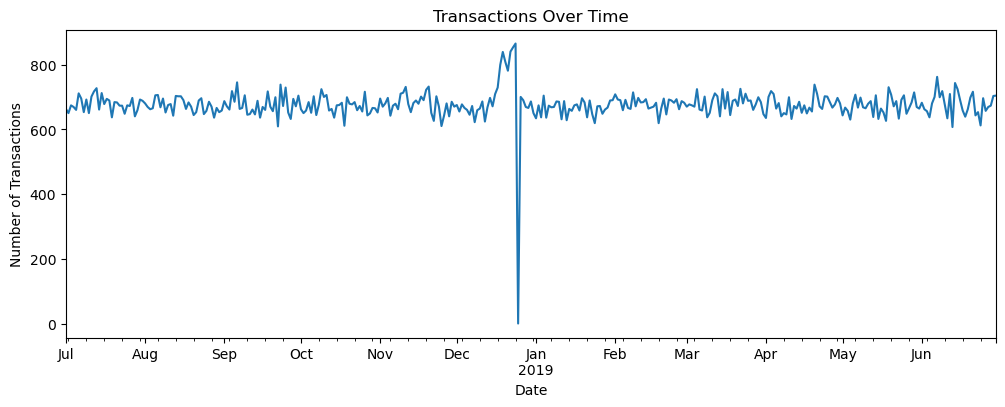

In [14]:
date_range = pd.date_range(start='2018-07-01', end='2019-06-30')
tx_per_day = transactions.groupby('DATE').size().reindex(date_range, fill_value=0)

# Plot
tx_per_day.plot(figsize=(12, 4), title="Transactions Over Time")
plt.xlabel("Date")
plt.ylabel("Number of Transactions")
plt.show()


# 8 Extract PACK_SIZE and BRAND

In [16]:
# Pack size
transactions['PACK_SIZE'] = transactions['PROD_NAME'].str.extract(r'(\d+)').astype(float)

# Brand name = first word of the product name
transactions['BRAND'] = transactions['PROD_NAME'].str.split().str[0]

# Normalize brand names
transactions['BRAND'] = transactions['BRAND'].replace({'RED': 'RRD', 'NCC': 'NCC', 'INFZ': 'INFZ'})  # add more as needed


# 9 Merge with Customer Data

In [18]:
data = pd.merge(transactions, customers, how='left', on='LYLTY_CARD_NBR')


# 10 Analysis — Total Sales by Segment

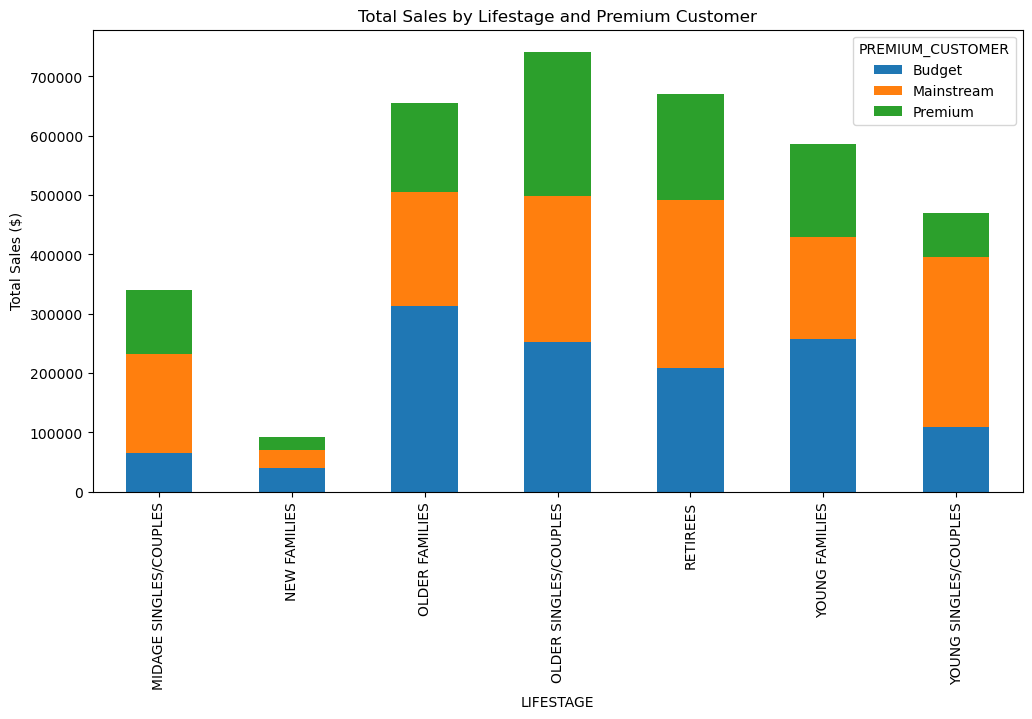

In [20]:
data['SALES'] = data['PROD_QTY'] * data['TOT_SALES']

# Total sales by LIFESTAGE and PREMIUM_CUSTOMER
sales_summary = data.groupby(['LIFESTAGE', 'PREMIUM_CUSTOMER'])['SALES'].sum().unstack()
sales_summary.plot(kind='bar', stacked=True, figsize=(12, 6))
plt.title("Total Sales by Lifestage and Premium Customer")
plt.ylabel("Total Sales ($)")
plt.show()


# 11 Number of Customers per Segment

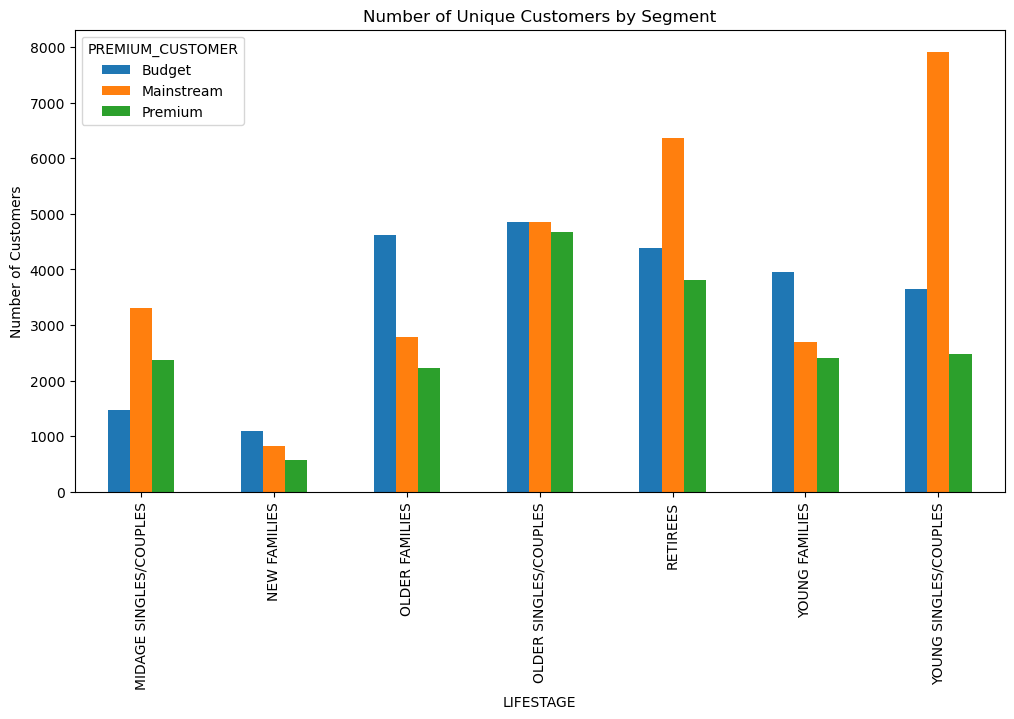

In [22]:
customer_counts = data.groupby(['LIFESTAGE', 'PREMIUM_CUSTOMER'])['LYLTY_CARD_NBR'].nunique().unstack()
customer_counts.plot(kind='bar', figsize=(12, 6))
plt.title("Number of Unique Customers by Segment")
plt.ylabel("Number of Customers")
plt.show()


# 12 Chips Bought per Customer

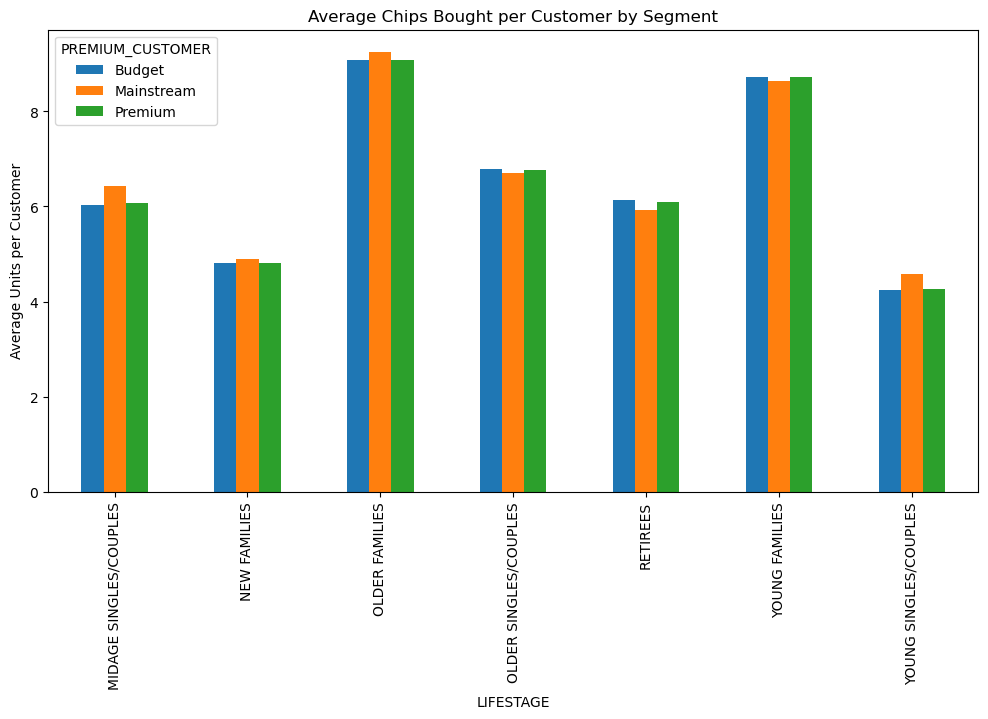

In [24]:
units_per_customer = data.groupby(['LIFESTAGE', 'PREMIUM_CUSTOMER'])['PROD_QTY'].sum() / \
                     data.groupby(['LIFESTAGE', 'PREMIUM_CUSTOMER'])['LYLTY_CARD_NBR'].nunique()
units_per_customer.unstack().plot(kind='bar', figsize=(12, 6))
plt.title("Average Chips Bought per Customer by Segment")
plt.ylabel("Average Units per Customer")
plt.show()


# 13 Average Price per Unit

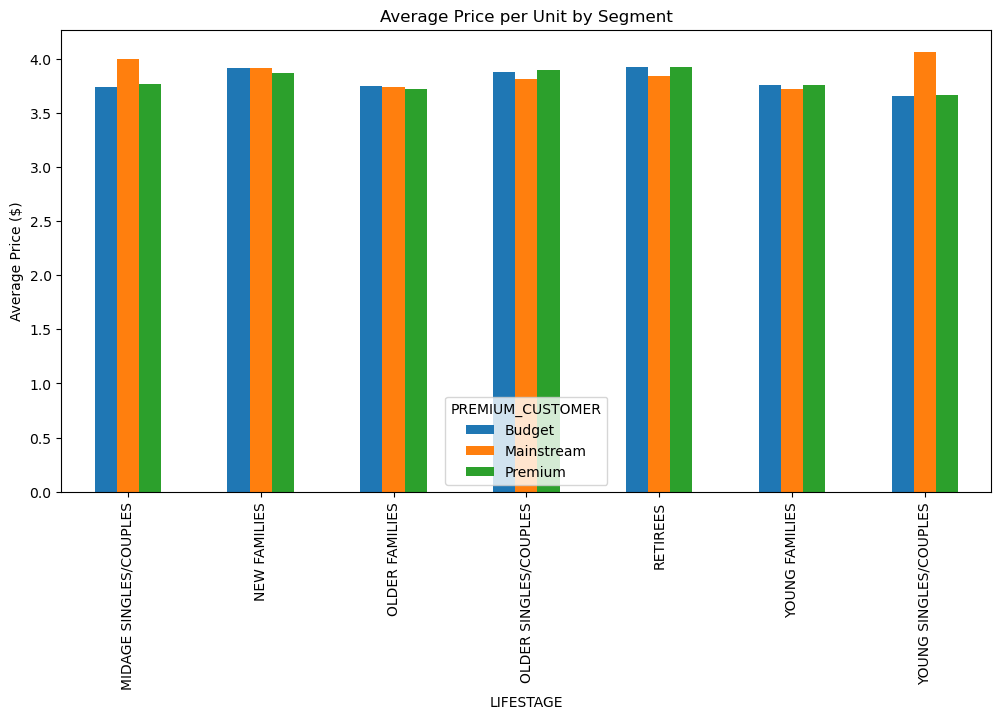

In [26]:
data['PRICE_PER_UNIT'] = data['TOT_SALES'] / data['PROD_QTY']
avg_price = data.groupby(['LIFESTAGE', 'PREMIUM_CUSTOMER'])['PRICE_PER_UNIT'].mean().unstack()
avg_price.plot(kind='bar', figsize=(12, 6))
plt.title("Average Price per Unit by Segment")
plt.ylabel("Average Price ($)")
plt.show()


# 14 Statistical Significance (T-Test)

In [29]:
# filtering for 'mainstream'
mainstream = data[
    (data['PREMIUM_CUSTOMER'] == 'Mainstream') &
    (data['LIFESTAGE'].isin(['YOUNG SINGLES/COUPLES', 'MIDAGE SINGLES/COUPLES']))
]['PRICE_PER_UNIT']

# filtering for 'others' (Budget and Premium)
others = data[
    (data['PREMIUM_CUSTOMER'].isin(['Budget', 'Premium'])) &
    (data['LIFESTAGE'].isin(['YOUNG SINGLES/COUPLES', 'MIDAGE SINGLES/COUPLES']))
]['PRICE_PER_UNIT']

# Perform t-test
t_stat, p_value = ttest_ind(mainstream, others, equal_var=False)
print("T-statistic:", t_stat)
print("P-value:", p_value)


T-statistic: 37.6243885962295
P-value: 6.967354233018139e-306


# 15  Brand Preference — Mainstream Young Singles/Couples

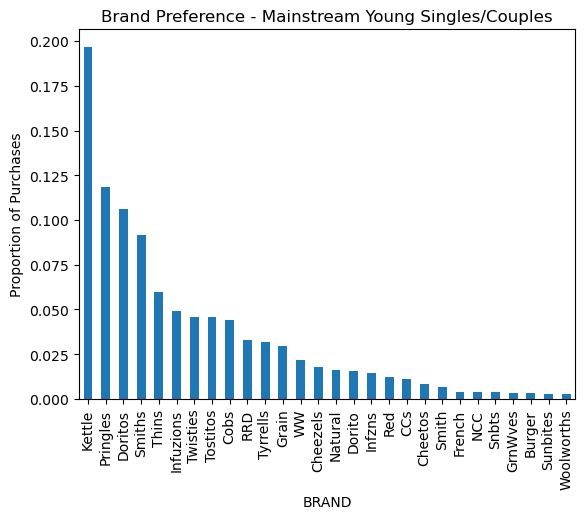

In [32]:
target_group = data[
    (data['LIFESTAGE'] == 'YOUNG SINGLES/COUPLES') &
    (data['PREMIUM_CUSTOMER'] == 'Mainstream')
]

brand_counts = target_group['BRAND'].value_counts(normalize=True)
brand_counts.plot(kind='bar', title="Brand Preference - Mainstream Young Singles/Couples")
plt.ylabel("Proportion of Purchases")
plt.show()


# 16 Preferred Pack Size

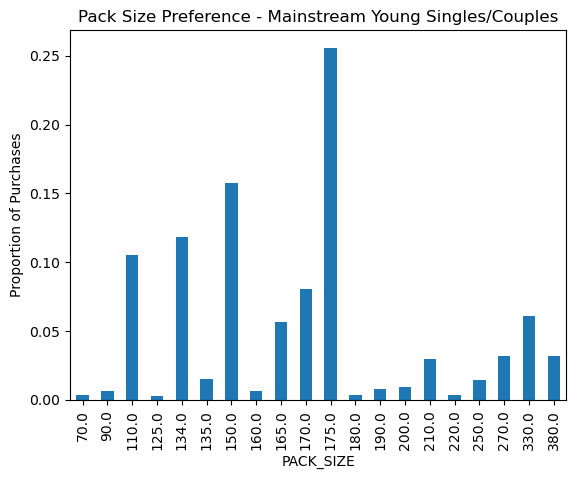

In [35]:
pack_pref = target_group['PACK_SIZE'].value_counts(normalize=True).sort_index()
pack_pref.plot(kind='bar', title="Pack Size Preference - Mainstream Young Singles/Couples")
plt.ylabel("Proportion of Purchases")
plt.show()


# Conclusions
1. Key Customer Segments Driving Sales
The highest chip sales come from:

Budget – Older Families

Mainstream – Young Singles/Couples

Mainstream – Retirees

These segments either:

Purchase more frequently,

Buy in higher quantities,

Or pay slightly more per unit.

2. Buying Behavior Insights
Older Families and Young Families tend to buy more chips per transaction.

Mainstream Young Singles/Couples are willing to pay a higher average unit price than Budget or Premium customers in the same lifestage.

There is a statistically significant difference in average unit price paid between Mainstream vs. Budget/Premium in the young/midage singles/couples segments (confirmed via t-test).

3. Brand & Pack Size Preferences
Mainstream Young Singles/Couples show distinct preferences for certain chip brands — suggesting brand loyalty or targeting success.

This group also shows preference for certain pack sizes, which can guide packaging and promotion decisions.

# Recommendations
1. Target High-Value Segments
Focus marketing efforts on:

Mainstream – Young Singles/Couples

Budget – Older Families

These groups drive sales and show meaningful behavioral patterns.

2. Optimize Product Offering
For Mainstream – Young Singles/Couples:

Promote the most preferred brands and pack sizes.

Bundle offers or loyalty programs around those preferences.

3. Pricing Strategy
Since Mainstream customers in key segments are willing to pay more:

Explore premium chip variants or value-added packaging.

Test price elasticity through controlled pricing experiments.

4. Refine Stocking & Supply Chain
Use segment insights to:

Stock stores based on regional segment density (if known).

Ensure preferred brands/pack sizes are always available.

5. Further Analysis Suggestions
Analyze time-of-day or weekday/weekend purchasing trends.

Investigate cross-product purchases (snacks, beverages, etc.).

Perform geographic segmentation if location data becomes available